Danny Abraham & Jad Abi Zaki
<center><h1>CMPS 351</h1></center>
<center><h2>Assignment 10</h2></center>

In [283]:
import numpy as np
import numpy.linalg as la
from bunch import Bunch
import scipy.optimize

## Central Path 
---

#### The convex problem: 
$$ \underset{ x}min \qquad\qquad f_0(x) $$
$$ \textit{subject to}\qquad Ax = b$$
$$\qquad\qquad\qquad f_i(x)\le 0$$




#### Log Barrier Problem

$$ \;\underset{x}min\qquad f_0(x) - \tau\sum_{i=1}^{m} log(-f_i(x))$$
$$ \textit{subject to}\qquad Ax = b\qquad\qquad$$

#### KKT Conditions:

$$ \nabla f_0 - \tau\frac{\nabla f_i(x)}{f_i(x)}- A^t\nu = 0  $$

$$ Ax - b = 0 $$

$$  -\lambda f(x) - \tau\textbf{1} = 0$$

$$ -f(x) \ge 0 $$

$$ \lambda \ge 0 $$

## Interior Point Method for LP
---

In [284]:
A = np.ones([100, 150])
print(A.shape)

b = np.ones([100, 1])
print(b.shape)

nu = np.ones([100, 1])
print(nu.shape)

lam = np.zeros([150, 1]) + 0.5
print(lam.shape)

p = np.ones([150, 1])
print(p.shape)

tau = 1

x = np.ones([150, 1])

(100, 150)
(100, 1)
(100, 1)
(150, 1)
(150, 1)


In [285]:
np.random.seed(9727)            # seed the random number generator
n = 150 
p = 100

# Generate random data
A = np.hstack( (np.random.randn(p, n-p), np.eye(p)) ) 
b = A @ np.random.rand(n)
pobj = np.concatenate( (np.random.randn(n-p), np.zeros(p)) ) 



# Solution may be compared to the one generated by linprog
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
solution = scipy.optimize.linprog(pobj, method='interior-point', A_eq = A, b_eq = b)
print(solution)

     con: array([-3.48965301e-12, -1.10311760e-11,  1.28297373e-12,  2.14557261e-11,
        2.78532752e-11, -4.83801887e-12,  8.16458012e-12, -2.17603713e-11,
       -1.15454313e-11, -2.25746088e-11, -3.43982620e-11,  1.91597849e-11,
       -2.72137868e-11,  3.59445806e-12,  1.05748743e-11, -7.90656429e-12,
       -7.04112324e-11, -2.84021695e-11, -1.53148605e-11,  1.05426778e-11,
        1.67865721e-13, -1.57056590e-11, -2.04636308e-11, -9.17088627e-12,
       -2.31876740e-11, -1.46211931e-11,  2.60222954e-11, -3.05782066e-11,
        2.69695377e-12,  1.13766774e-11, -1.47419854e-11, -2.73399081e-11,
       -2.14628315e-11,  2.00524042e-11,  3.15512061e-11, -5.92736971e-12,
        2.03164152e-11,  4.91902075e-11,  1.45181644e-11,  8.34110558e-12,
        1.40891743e-11,  1.32092115e-11, -7.83906273e-12,  4.38160619e-12,
        1.10857989e-11, -4.21795932e-11, -2.13007390e-11, -3.69211328e-11,
       -5.48339152e-12, -5.77760062e-13, -1.84536830e-11, -3.96589428e-11,
        3.49564

In [286]:
#b = b.reshape([100, 1])

#### Finding a  Feasible Starting Point

In [287]:
def func(x):
    return - np.sum(np.log(x))

In [288]:
def res(x, nu):
    r1 = -(1/x) + A.T@nu
    r2 = A@x - b
    r = np.hstack([r1, r2])
    r = r.T
    return r

In [289]:
def jacobian(x):
    h = (1/(x**2))
    h = np.diag(h)
    j1 = np.hstack([h, A.T])
    j2 = np.hstack([A, np.zeros([p, p])])
    j = np.vstack([j1, j2])
    return j

In [290]:
def btLineSearch(x, nu, t, p, alpha = 0.01, beta = 0.8):
    while (x + t*p[:n]<0).any():
        t=t*beta
    while (la.norm(res(x + t*p[:n], nu + t*p[n:])) >= (1 - alpha*t)*la.norm(res(x,nu))):
        t *= beta
    return t

In [291]:
def infeasible_newton(x0, nu0, tol = 2e-6):
    x = x0
    nu= nu0
    histx  = np.array([x0])
    histnu = np.array([nu0])
    while(la.norm(res(x, nu)) > tol):
        print(la.norm(res(x,nu)), end='\r')
        p = la.solve(jacobian(x), - res(x, nu))
        t = btLineSearch(x,nu,1,p)
        x = x + t*p[:n]
        nu = nu + t*p[n:]
        histx = np.vstack([histx , x])
        histnu = np.vstack([histnu , nu])
    return histx, histnu , x, nu 

In [292]:
x = np.ones(n)
nu = np.zeros(p)
histx, histnu, xstar, nustar = infeasible_newton(x, nu)

In [309]:
(xstar>=0).all()

True

In [314]:
(abs(A@xstar-b)<0.00000000000001).all()

True

#### Residual

In [294]:
xstar = xstar.reshape([150, 1])
nustar = nustar.reshape([100, 1])
b = b.reshape([100, 1])

In [320]:
def residual(x, nu, lam, tau):
    r1 = pobj.reshape([150, 1]) + A.T@nu - lam #p + A.T@nu + (-np.ones(150)).T@lam
    r2 = A@x - b
    r3 = np.diag(lam[:, 0])@x - tau*np.ones([150, 1])
    r = np.vstack([r1, r2, r3])
    return r

In [296]:
residual(xstar, nustar, lam).shape

(400, 1)

#### Jacobian

In [297]:
def jacobian(x, nu, lam):
    j11 = np.zeros([150, 150])
    j12 = A.T
    j13 = -np.identity(150)
    j1 = np.hstack([j11, j12, j13])
    
    j21 = A
    j22 = np.zeros([100, 100])
    j23 = np.zeros([100, 150])
    j2  = np.hstack([j21, j22, j23])
    
    j31 = np.diag(lam[:, 0])
    j32 = np.zeros([150, 100])
    j33 = np.diag(x[:, 0])
    j3  = np.hstack([j31, j32, j33])
    
    j   = np.vstack([j1, j2, j3])
    return j

In [298]:
jacobian(xstar, nustar, lam).shape

(400, 400)

#### Path Following Method

In [315]:
def backtrack(x, nu, lam, t, p,tau, alpha=0.01, beta=0.8):
    delta_x = p[:150].reshape([150, 1])
    delta_nu = p[150:250].reshape([100, 1])
    delta_lam = p[250:].reshape([150, 1])
        
    while (-(x + t*delta_x)).any() <0:
        #print("Stuck Second")
        t *= beta    
    while la.norm(residual(x + t*delta_x, nu + t*delta_nu, lam + t*delta_lam,tau)) >= (1 - alpha*t)*la.norm(residual(x, nu, lam, tau)):
        #print("Stuck First")
        t *= beta

    return t

In [318]:
def interior_LP(x0, nu0, lam0, tau, mu = 2, tol1 = 1e-6, tol2=1e-6):
    
    iterations  = 0
    x_star      = None
    nu_star     = None
    lam_star    = None
    dual_gap    = None
    
    x = x0
    nu = nu0
    lam = lam0
    
    while 150 * tau >= tol1:
        while la.norm(residual(x, nu, lam)) >= tol2:
            
            print(la.norm(residual(x, nu, lam)))
            
            p = la.solve(jacobian(x, nu, lam), - residual(x, nu, lam))

            delta_x = p[:150].reshape([150, 1])
            delta_nu = p[150:250].reshape([100, 1])
            delta_lam = p[250:].reshape([150, 1])
            
            s_max = np.amin(np.abs(np.divide(lam , delta_lam)))
            t = min(1, 0.99*s_max)
            
            print(t)
            t = backtrack(x, nu, lam, t, p,tau)
            
            x = x + t*delta_x
            nu = nu + t*delta_nu
            lam = lam + t* delta_lam
            
            iterations += 1
            
        x_star = x
        nu_star = nu
        lam_star = lam
            
        tau = tau / mu
    
    solution = Bunch()
    solution.x_star = x_star
    solution.nu_star = nu_star
    solution.lam_star = lam_star
    solution.dual_gap = 150 * tau
    solution.iterations = iterations
    
    return solution

In [321]:
yo = interior_LP(xstar, nustar, lam, tau)

TypeError: residual() missing 1 required positional argument: 'tau'

In [302]:
yo.values()

dict_values([array([[0.11173589],
       [0.08535179],
       [0.98899129],
       [1.01489407],
       [0.09493581],
       [0.81871719],
       [0.45502234],
       [0.81082496],
       [0.3797317 ],
       [0.86249672],
       [0.72337643],
       [0.1660932 ],
       [0.12340816],
       [0.42459848],
       [0.14519714],
       [0.36061938],
       [0.58617688],
       [0.77254208],
       [0.6145982 ],
       [0.66858366],
       [0.08713506],
       [0.63099985],
       [0.41463186],
       [0.36518635],
       [0.33602363],
       [0.62108876],
       [0.30999801],
       [0.71885336],
       [0.12656571],
       [0.34118588],
       [1.08780023],
       [0.7610874 ],
       [0.83928113],
       [0.05386284],
       [0.22082898],
       [0.24341414],
       [0.34965995],
       [0.70114288],
       [0.6521842 ],
       [0.33233778],
       [0.3831273 ],
       [0.8690352 ],
       [0.46359952],
       [0.43617976],
       [0.3632257 ],
       [0.06681438],
       [0.26352558],


In [306]:
yo.x_star

array([[0.11173589],
       [0.08535179],
       [0.98899129],
       [1.01489407],
       [0.09493581],
       [0.81871719],
       [0.45502234],
       [0.81082496],
       [0.3797317 ],
       [0.86249672],
       [0.72337643],
       [0.1660932 ],
       [0.12340816],
       [0.42459848],
       [0.14519714],
       [0.36061938],
       [0.58617688],
       [0.77254208],
       [0.6145982 ],
       [0.66858366],
       [0.08713506],
       [0.63099985],
       [0.41463186],
       [0.36518635],
       [0.33602363],
       [0.62108876],
       [0.30999801],
       [0.71885336],
       [0.12656571],
       [0.34118588],
       [1.08780023],
       [0.7610874 ],
       [0.83928113],
       [0.05386284],
       [0.22082898],
       [0.24341414],
       [0.34965995],
       [0.70114288],
       [0.6521842 ],
       [0.33233778],
       [0.3831273 ],
       [0.8690352 ],
       [0.46359952],
       [0.43617976],
       [0.3632257 ],
       [0.06681438],
       [0.26352558],
       [0.346

In [304]:
solution.x

array([3.19113347e-01, 1.23790061e-12, 1.40267652e+00, 1.02711427e+00,
       1.07991208e-02, 1.06453868e+00, 1.91100942e-01, 1.42157824e+00,
       1.24133754e-02, 9.41924038e-01, 4.40352987e-01, 1.86271954e-01,
       3.57248774e-01, 5.60421394e-01, 2.89119813e-01, 1.98969969e-01,
       5.32761763e-01, 5.65638861e-01, 5.33224765e-01, 7.79170816e-01,
       2.01684002e-01, 8.36668858e-01, 3.85641927e-01, 3.75520296e-01,
       2.74166282e-01, 1.81482834e-01, 1.03364873e-01, 1.11404813e+00,
       1.18672117e-11, 5.63656412e-01, 6.88530511e-01, 9.22901410e-01,
       9.56819641e-01, 2.79526544e-12, 1.42491419e-01, 2.83386018e-01,
       7.12063344e-02, 7.83780739e-01, 7.39582721e-01, 1.40928269e-12,
       3.80660211e-01, 9.07770805e-01, 4.18934003e-01, 6.46374204e-01,
       4.48985120e-01, 1.15137908e-11, 4.23639135e-12, 1.91466336e-01,
       4.26491666e-12, 7.85892033e-01, 1.10150544e-11, 2.37730052e-10,
       6.31784556e-02, 6.32968813e-12, 2.16038955e-11, 9.41847342e-12,
      

In [305]:
pobj@solution.x

-3.7186319504597276

# Inverse barrier

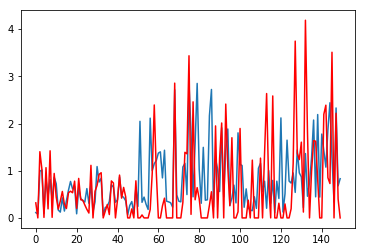

In [307]:
plt.plot(yo.x_star)
plt.plot(solution.x, color='red')